In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
sigma = 10.
rho = 28.
beta = 8 / 3

scaling_factor = 40.

In [3]:
def dynamic(t, r):
    """
    Rhs of the Lorenz system
    """
    x, y, z = r
    
    fx = sigma * (y - x)
    fy = x * (rho - z) - y
    fz = x * y - beta * z
    
    return np.array([fx, fy, fz])


def scaled_dynamic(t, r):
    """
    Rhs of the scaled Lorenz system
    """
    x, y, z = r
    
    fx = sigma * (y - x)
    fy = scaling_factor * x * (rho / scaling_factor - z) - y
    fz = scaling_factor * x * y - beta * z
    
    return np.array([fx, fy, fz])

In [4]:
def get_solution(init_val, max_t, scaled=True):
    
    if scaled:
        sol = solve_ivp(scaled_dynamic, [0, max_t], init_val, t_eval=np.linspace(0, max_t, 10 * max_t))
    
    else:
        sol = solve_ivp(dynamic, [0, max_t], init_val, t_eval=np.linspace(0, max_t, 10 * max_t))
    
    return sol.y.T


def plot_3d(points):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
    
    return fig, ax

In [5]:
def solutions_second_half(init_vals, max_t):
    
    n_solutions = len(init_vals)
    len_per_sol = len(get_solution(init_vals[0], max_t)) // 2
    
    points = np.empty((n_solutions * len_per_sol, 3), dtype=float)
    
    for i, init_val in enumerate(init_vals):
        
        sol = get_solution(init_val, max_t)
        points[i * len_per_sol : (i+1) * len_per_sol, :] = sol[len(sol) // 2 :, :]
    
    return points

In [6]:
# random initial values in [-40, 40] x [-40, 40] x [0, 40]
n_inits = 1000

init_x = np.random.uniform(-40, 40, n_inits)
init_y = np.random.uniform(-40, 40, n_inits)
init_z = np.random.uniform(0, 50, n_inits)

init_vals = np.vstack([init_x, init_y, init_z]).T

scaled = True

if scaled:
    init_vals *= scaling_factor

max_t = 50

In [7]:
points = solutions_second_half(init_vals, max_t)

print(points.shape)

(250000, 3)


In [8]:
print(max(points[:,0]), max(points[:,1]), max(points[:,2]))
print(min(points[:,0]), min(points[:,1]), min(points[:,2]))

0.4790009167896035 0.6614549888366305 1.182141171204014
-0.48407535712471433 -0.6651465340707063 0.04004790032650265


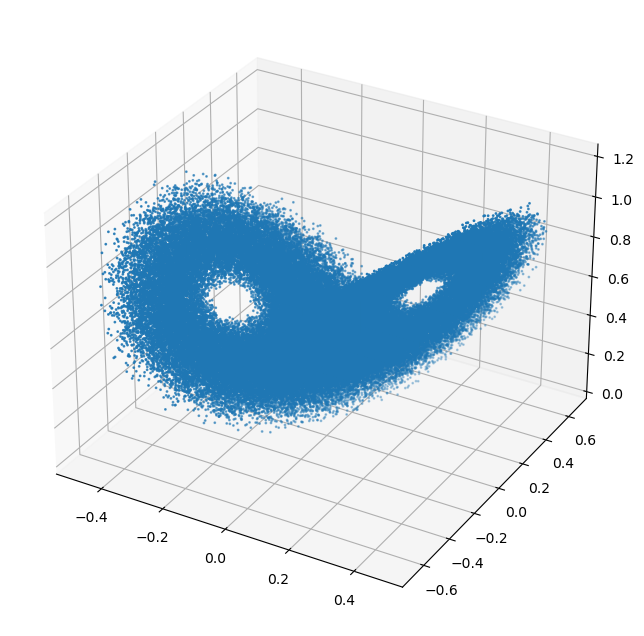

In [14]:
n_points_plot = 100000

np.random.shuffle(points)
fig, ax = plot_3d(points[: n_points_plot,:])
plt.show()

In [10]:
# get noisy initial values
init_value_cloud = np.empty((3 * len(points), 3), dtype=float)

var = .0025
cov = np.diag(np.full(3, var))

for i, point in enumerate(points):
    
    init_value_cloud[3 * i : 3 * (i + 1), :] = np.random.multivariate_normal(point, cov, size=3)

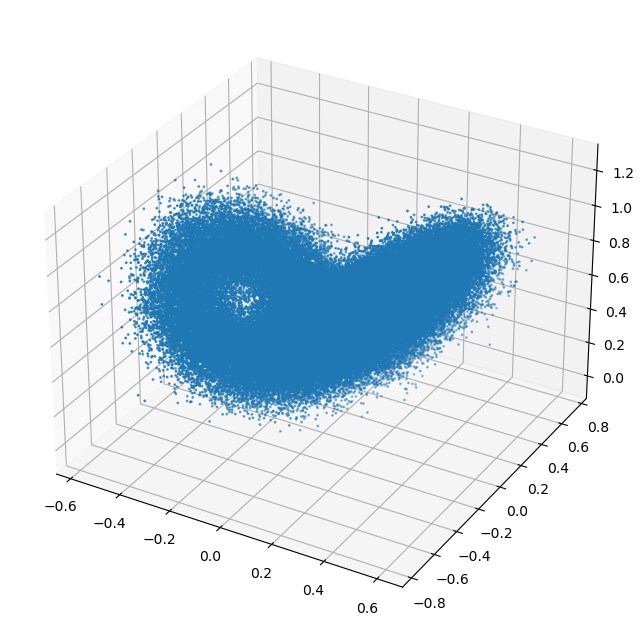

In [15]:
np.random.shuffle(init_value_cloud)
fig, ax = plot_3d(init_value_cloud[: n_points_plot,:])
plt.show()

In [12]:
# save initial values for tcPINN training
for n_points in [1e4, 5e4, 1e5, 2e5, 3e5, 5e5]:
    
    np.random.shuffle(init_value_cloud)
    np.save(f"init_values_{int(n_points)}.npy", init_value_cloud[:int(n_points), :])